In [1]:
! pip install qiskit
! pip install qiskit-aer
! pip install pylatexenc

# Quantum K-nearest neighbors
#### **Objectives**
    - Understand the basics of K-nearest neigbors in classical and quantum contexts.
    - Apply a quantum-enhanced version of k-NN using quantum distance measures.
    - Prepare datasets for use in quantum machine learning tasks
    - Work through hands-on coding examples.
    - Solve exercises to reinforce understanding.

### Classical k-Nearest Neighbors
What is k-Nearest Neighbors (k-NN)?

k-NN is a **Supervised** machine learning algorithm used for classification and regression tasks.

Given a dataset of labeled points, when a new data point is introduced, k-NN classifies it by identifying the **‘k’** nearest data points and voting for the most common class (for classification) or averaging their values (for regression).

The algorithm uses a distance measure, usually Euclidean distance.

The Euclidean distance between two points $$ \mathbf{x} = (x_1, x_2, \dots, x_n) $$ and $$ \mathbf{y} = (y_1, y_2, \dots, y_n) $$ in $ n $-dimensional space is given by:

$$
d(\mathbf{x}, \mathbf{y}) = (\sum_{i=1}^{n} (x_i - y_i)^2)^{1/2}
$$


Classification: After calculating distances, the algorithm selects the majority class from the ‘k’ nearest neighbors.

**The following Python code demonstrates a simple example of classical k-NN using *scikit-learn*.<br>
In it, we try to determine if a game of golf is/is not in play, based on various factors like Temperature, Humidity and more.**


**Import all necessary libraries**

In [2]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

**Generate Sample Dataset**

In [3]:
# Create synthetic 2D dataset
X, y = make_classification(
    n_samples=200,        # Total number of samples
    n_features=2,         # Number of features (2D for easy visualization)
    n_redundant=0,        # No redundant features
    n_informative=2,      # Both features are informative
    n_clusters_per_class=1,  # One cluster per class
    random_state=42       # For reproducible results
)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

print(f"  - Training samples: {len(X_train)}")
print(f"  - Test samples: {len(X_test)}")
print(f"  - Features: {X.shape[1]}")
print(f"  - Classes: {len(np.unique(y))}")

  - Training samples: 140
  - Test samples: 60
  - Features: 2
  - Classes: 2


**Distance Calculation Function**

In [4]:
def euclidean_distance(point1, point2):
    """
    Calculate Euclidean distance between two points

    Args:
        point1: First data point (array)
        point2: Second data point (array)

    Returns:
        float: Euclidean distance between the points
    """
    # Calculate squared differences for each dimension
    squared_diffs = (point1 - point2) ** 2

    # Sum all squared differences
    sum_squared_diffs = np.sum(squared_diffs)

    # Take square root to get Euclidean distance
    distance = np.sqrt(sum_squared_diffs)

    return distance

    # Test the distance function
test_point1 = np.array([1, 2])
test_point2 = np.array([4, 6])
test_distance = euclidean_distance(test_point1, test_point2)
print(f"✓ Distance function test: distance = {test_distance:.2f}")

✓ Distance function test: distance = 5.00


**Find k Nearest Neighbors**

In [5]:
def find_k_nearest_neighbors(test_point, X_train, k):
    """
    Find k nearest neighbors for a test point

    Args:
        test_point: Point to classify
        X_train: Training data points
        k: Number of neighbors to find

    Returns:
        tuple: (indices of k nearest neighbors, their distances)
    """
    distances = []

    # Calculate distance to each training point
    for i, train_point in enumerate(X_train):
        dist = euclidean_distance(test_point, train_point)
        distances.append((dist, i))  # Store (distance, index) pair

    # Sort by distance (smallest first)
    distances.sort(key=lambda x: x[0])

    # Extract k nearest neighbors
    k_nearest = distances[:k]
    neighbor_indices = [idx for dist, idx in k_nearest]
    neighbor_distances = [dist for dist, idx in k_nearest]

    return neighbor_indices, neighbor_distances

# Test finding neighbors
k = 3
test_point = X_test[0]
neighbor_indices, neighbor_distances = find_k_nearest_neighbors(test_point, X_train, k)

print(f"✓ Found {k} nearest neighbors:")
for i, (idx, dist) in enumerate(zip(neighbor_indices, neighbor_distances)):
    print(f"  Neighbor {i+1}: index={idx}, distance={dist:.3f}")

✓ Found 3 nearest neighbors:
  Neighbor 1: index=115, distance=0.255
  Neighbor 2: index=134, distance=0.327
  Neighbor 3: index=98, distance=0.507


**Make Prediction Using Majority Vote**

In [6]:
def predict_single_point(test_point, X_train, y_train, k):
    """
    Predict class for a single test point using k-NN

    Args:
        test_point: Point to classify
        X_train: Training feature data
        y_train: Training labels
        k: Number of neighbors to consider

    Returns:
        int: Predicted class label
    """
    # Find k nearest neighbors
    neighbor_indices, _ = find_k_nearest_neighbors(test_point, X_train, k)

    # Get labels of k nearest neighbors
    neighbor_labels = [y_train[idx] for idx in neighbor_indices]

    # Count votes for each class
    vote_counts = Counter(neighbor_labels)

    # Get the class with most votes
    predicted_class = vote_counts.most_common(1)[0][0]

    return predicted_class, neighbor_labels, vote_counts

# Test single prediction
predicted_class, neighbor_labels, vote_counts = predict_single_point(
    test_point, X_train, y_train, k
)

print(f"✓ Single point prediction:")
print(f"  Test point: [{test_point[0]:.2f}, {test_point[1]:.2f}]")
print(f"  Neighbor labels: {neighbor_labels}")
print(f"  Vote counts: {dict(vote_counts)}")
print(f"  Predicted class: {predicted_class}")
print(f"  Actual class: {y_test[0]}")


✓ Single point prediction:
  Test point: [-0.62, 2.99]
  Neighbor labels: [np.int64(0), np.int64(0), np.int64(0)]
  Vote counts: {np.int64(0): 3}
  Predicted class: 0
  Actual class: 0


**Complete k-NN Classifier Class**

In [7]:
class KNNClassifier:
    def __init__(self, k=3):
        """
        Initialize k-NN classifier

        Args:
            k: Number of neighbors to consider
        """
        self.k = k
        self.X_train = None
        self.y_train = None

    def fit(self, X_train, y_train):
        """
        Fit the classifier (just store training data)
        k-NN is a lazy learner - no actual training happens

        Args:
            X_train: Training features
            y_train: Training labels
        """
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        """
        Predict classes for multiple test points

        Args:
            X_test: Test features

        Returns:
            array: Predicted class labels
        """
        predictions = []

        for test_point in X_test:
            predicted_class, _, _ = predict_single_point(
                test_point, self.X_train, self.y_train, self.k
            )
            predictions.append(predicted_class)

        return np.array(predictions)

    def predict_with_details(self, test_point):
        """
        Predict class with detailed information about the decision

        Args:
            test_point: Single test point

        Returns:
            tuple: (predicted_class, neighbor_info)
        """
        neighbor_indices, neighbor_distances = find_k_nearest_neighbors(
            test_point, self.X_train, self.k
        )

        neighbor_labels = [self.y_train[idx] for idx in neighbor_indices]
        vote_counts = Counter(neighbor_labels)
        predicted_class = vote_counts.most_common(1)[0][0]

        neighbor_info = {
            'indices': neighbor_indices,
            'distances': neighbor_distances,
            'labels': neighbor_labels,
            'votes': dict(vote_counts)
        }

        return predicted_class, neighbor_info

# Create and train classifier
knn = KNNClassifier(k=3)
knn.fit(X_train, y_train)

**Make Predictions and Evaluate**

In [8]:
# Make predictions on test set
y_pred = knn.predict(X_test)

# Calculate accuracy
accuracy = np.mean(y_pred == y_test) * 100

print(f"✓ Model evaluation:")
print(f"  k value: {knn.k}")
print(f"  Test accuracy: {accuracy:.1f}%")
print(f"  Correct predictions: {np.sum(y_pred == y_test)}/{len(y_test)}")

# Show detailed predictions for first 5 test points
print(f"\n✓ Detailed predictions for first 5 test points:")
for i in range(min(5, len(X_test))):
    test_point = X_test[i]
    predicted_class, neighbor_info = knn.predict_with_details(test_point)

    print(f"\n  Test point {i+1}: [{test_point[0]:.2f}, {test_point[1]:.2f}]")
    print(f"    Predicted: {predicted_class}, Actual: {y_test[i]}")
    print(f"    Neighbor distances: {[f'{d:.3f}' for d in neighbor_info['distances']]}")
    print(f"    Neighbor labels: {neighbor_info['labels']}")
    print(f"    Vote counts: {neighbor_info['votes']}")
    print(f"    Correct: {'✓' if predicted_class == y_test[i] else '✗'}")

✓ Model evaluation:
  k value: 3
  Test accuracy: 86.7%
  Correct predictions: 52/60

✓ Detailed predictions for first 5 test points:

  Test point 1: [-0.62, 2.99]
    Predicted: 0, Actual: 0
    Neighbor distances: ['0.255', '0.327', '0.507']
    Neighbor labels: [np.int64(0), np.int64(0), np.int64(0)]
    Vote counts: {np.int64(0): 3}
    Correct: ✓

  Test point 2: [0.47, 0.79]
    Predicted: 0, Actual: 0
    Neighbor distances: ['0.232', '0.246', '0.250']
    Neighbor labels: [np.int64(0), np.int64(0), np.int64(1)]
    Vote counts: {np.int64(0): 2, np.int64(1): 1}
    Correct: ✓

  Test point 3: [0.30, 0.23]
    Predicted: 1, Actual: 0
    Neighbor distances: ['0.186', '0.205', '0.313']
    Neighbor labels: [np.int64(1), np.int64(1), np.int64(0)]
    Vote counts: {np.int64(1): 2, np.int64(0): 1}
    Correct: ✗

  Test point 4: [0.18, 0.37]
    Predicted: 1, Actual: 1
    Neighbor distances: ['0.224', '0.307', '0.333']
    Neighbor labels: [np.int64(0), np.int64(1), np.int64(1)]
  

**Visualize Results**

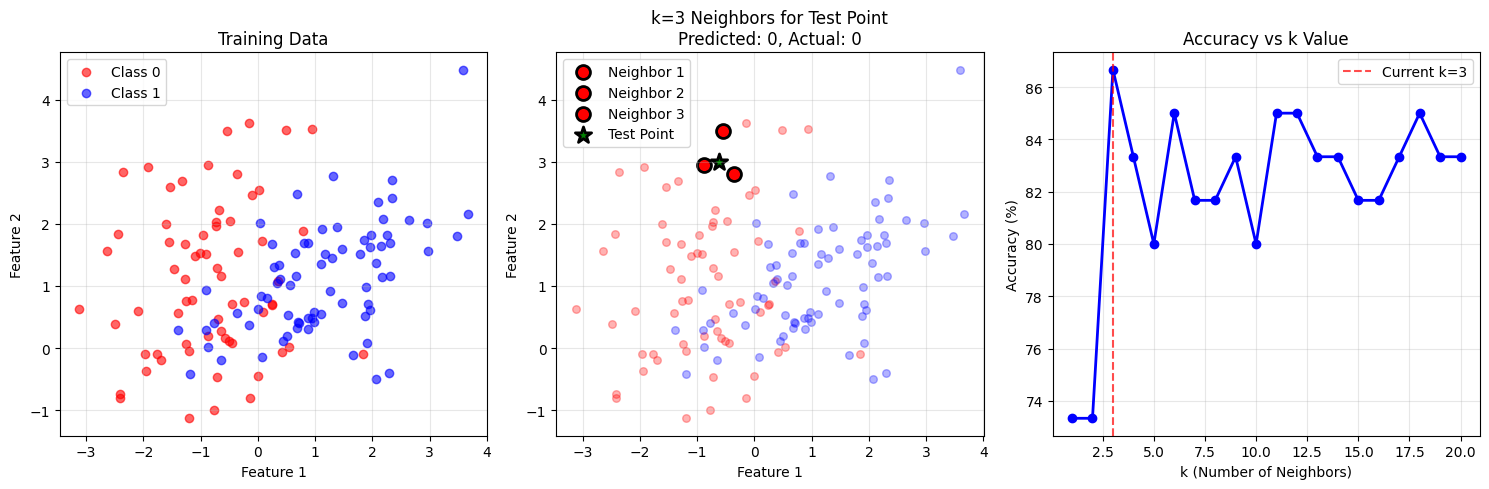

✓ Best k value: 3 with accuracy: 86.7%


In [9]:
plt.figure(figsize=(15, 5))

# Plot 1: Training Data
plt.subplot(1, 3, 1)
colors = ['red', 'blue']
for class_label in np.unique(y_train):
    mask = y_train == class_label
    plt.scatter(X_train[mask, 0], X_train[mask, 1],
               c=colors[class_label], alpha=0.6,
               label=f'Class {class_label}')
plt.title('Training Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Visualization of k=3 neighbors for a specific point
plt.subplot(1, 3, 2)

# Choose an interesting test point
test_idx = 0
test_point = X_test[test_idx]
predicted_class, neighbor_info = knn.predict_with_details(test_point)

# Plot all training data
for class_label in np.unique(y_train):
    mask = y_train == class_label
    plt.scatter(X_train[mask, 0], X_train[mask, 1],
               c=colors[class_label], alpha=0.3, s=30)

# Highlight the 3 nearest neighbors
neighbor_indices = neighbor_info['indices']
for i, idx in enumerate(neighbor_indices):
    plt.scatter(X_train[idx, 0], X_train[idx, 1],
               c=colors[y_train[idx]], s=100,
               marker='o', edgecolors='black', linewidth=2,
               label=f'Neighbor {i+1}' if i < 3 else "")

# Plot the test point
plt.scatter(test_point[0], test_point[1],
           c='green', s=150, marker='*',
           edgecolors='black', linewidth=2,
           label='Test Point')

plt.title(f'k=3 Neighbors for Test Point\nPredicted: {predicted_class}, Actual: {y_test[test_idx]}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Accuracy vs k
plt.subplot(1, 3, 3)
k_values = range(1, 21)
accuracies = []

for k in k_values:
    temp_knn = KNNClassifier(k=k)
    temp_knn.fit(X_train, y_train)
    temp_pred = temp_knn.predict(X_test)
    temp_accuracy = np.mean(temp_pred == y_test) * 100
    accuracies.append(temp_accuracy)

plt.plot(k_values, accuracies, 'bo-', linewidth=2, markersize=6)
plt.axvline(x=knn.k, color='red', linestyle='--', alpha=0.7,
           label=f'Current k={knn.k}')
plt.title('Accuracy vs k Value')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

best_k = k_values[np.argmax(accuracies)]
best_accuracy = max(accuracies)
print(f"✓ Best k value: {best_k} with accuracy: {best_accuracy:.1f}%")

# Quantum k-NN

In classical k-NN, we calculate the distance between data points using Euclidean distance. In quantum k-NN, we can exploit quantum states to compute distances more efficiently. It can use quantum states to measure the distance between points. For simplicity, assume the use of quantum states to represent feature vectors and a quantum circuit to compute the distance between them.

Quantum Advantage

Quantum algorithms like Grover's search can speed up certain aspects of distance computation, and quantum computers can evaluate multiple distances simultaneously using superposition.

Quantum k-NN Algorithm

The algorithm works similarly to classical k-NN but utilizes quantum distance measures to calculate the nearest neighbors.

## Mathematical Framework for Quantum Distance Calculation

### Classical Data Encoding

Classical data points are first preprocessed and then encoded into quantum states using angle encoding. For a classical data point $\mathbf{x} = (x_1, x_2, \ldots, x_d)$ where each feature is scaled to the range $[0, \pi]$:

\begin{equation}
|\psi(\mathbf{x})\rangle = \bigotimes_{j=1}^{d} \left(\cos\left(\frac{x_j}{2}\right)|0\rangle_j + \sin\left(\frac{x_j}{2}\right)|1\rangle_j\right)
\end{equation}

This creates a product state where each qubit encodes one feature through the rotation angle $x_j$.

### Quantum State Overlap (Fidelity)

The similarity between two pure quantum states $|\psi_1\rangle$ and $|\psi_2\rangle$ is quantified by their overlap (squared fidelity):

\begin{equation}
F(|\psi_1\rangle, |\psi_2\rangle) = |\langle\psi_1|\psi_2\rangle|^2
\end{equation}

For angle-encoded states representing data points $\mathbf{x}_1$ and $\mathbf{x}_2$:

\begin{equation}
F = \left|\prod_{j=1}^{d} \left[\cos\left(\frac{x_{1,j}}{2}\right)\cos\left(\frac{x_{2,j}}{2}\right) + \sin\left(\frac{x_{1,j}}{2}\right)\sin\left(\frac{x_{2,j}}{2}\right)\right]\right|^2
\end{equation}

\begin{equation}
F = \left|\prod_{j=1}^{d} \cos\left(\frac{x_{1,j} - x_{2,j}}{2}\right)\right|^2
\end{equation}

### Swap Test Protocol

The swap test is a quantum algorithm that allows us to estimate the overlap between two quantum states. The probability of measuring the ancilla qubit in state $|0\rangle$ after the swap test protocol is:

\begin{equation}
P(0) = \frac{1 + |\langle\psi_1|\psi_2\rangle|^2}{2} = \frac{1 + F}{2}
\end{equation}


### Quantum Distance Metric

The quantum distance between two data points is defined as:

\begin{equation}
d_{\text{quantum}}(\mathbf{x}_1, \mathbf{x}_2) = 1 - |\hat{F}|
\end{equation}

Substituting the overlap estimation:

\begin{equation}
d_{\text{quantum}}(\mathbf{x}_1, \mathbf{x}_2) = 1 - \left|2 \cdot \frac{N_0}{N} - 1\right|
\end{equation}

**Import all required libraries**

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, circuit_drawer
from sklearn.datasets import make_classification, make_blobs
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

**Data Generation and Preprocessing**

In [11]:
# Generate a simple 2D dataset for demonstration
np.random.seed(42)
X, y = make_blobs(n_samples=100, centers=2, n_features=2,
                  random_state=42, cluster_std=1.5)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=42)

# Scale the features to [0, π] range for angle encoding
scaler = MinMaxScaler(feature_range=(0, np.pi))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Dataset shape: {X.shape}")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Classes: {np.unique(y)}")
print(f"Features scaled to range: [0, π]")

Dataset shape: (100, 2)
Training set: 70 samples
Test set: 30 samples
Classes: [0 1]
Features scaled to range: [0, π]


**Angle Encoding Function**

In [12]:
def angle_encode_data(circuit, data, qubits):
    """
    Encode classical data into quantum states using angle encoding.
    Each feature is encoded as a rotation angle on a qubit.

    Args:
        circuit: Quantum circuit to add gates to
        data: Classical data point (array of features)
        qubits: List of qubits to encode data on
    """
    for i, feature in enumerate(data):
        if i < len(qubits):
            # Use RY rotation to encode the feature value
            circuit.ry(feature, qubits[i])
    return circuit

**Swap Test Implementation**

In [13]:
def create_swap_test_circuit(data1, data2, n_features=2):
    """
    Create a quantum circuit that implements the swap test
    to measure similarity between two data points.

    Args:
        data1: First data point (encoded as angles)
        data2: Second data point (encoded as angles)
        n_features: Number of features to encode

    Returns:
        circuit: Quantum circuit implementing swap test
        ancilla: Ancilla qubit register
        classical: Classical register for measurement
    """
    # Create quantum registers
    # We need 2 * n_features qubits for the two data points + 1 ancilla
    qubits1 = QuantumRegister(n_features, 'q1')  # First data point
    qubits2 = QuantumRegister(n_features, 'q2')  # Second data point
    ancilla = QuantumRegister(1, 'anc')          # Ancilla qubit for swap test
    classical = ClassicalRegister(1, 'c')        # Classical bit for measurement

    # Create the circuit
    circuit = QuantumCircuit(qubits1, qubits2, ancilla, classical)

    # Encode the first data point
    angle_encode_data(circuit, data1, qubits1)

    # Encode the second data point
    angle_encode_data(circuit, data2, qubits2)

    # Initialize ancilla in superposition
    circuit.h(ancilla[0])

    # Apply controlled swaps between corresponding qubits
    for i in range(n_features):
        circuit.cswap(ancilla[0], qubits1[i], qubits2[i])

    # Measure ancilla in X basis (apply H then measure)
    circuit.h(ancilla[0])
    circuit.measure(ancilla[0], classical[0])

    return circuit, ancilla, classical

**DEMONSTRATION CIRCUIT VISUALIZATION**

Sample swap test circuit created with:
Data point 1: [2.08339139 0.07575744]
Data point 2: [0.98797229 2.52146509]
Circuit depth: 5
Number of qubits: 5

Quantum Circuit Diagram:


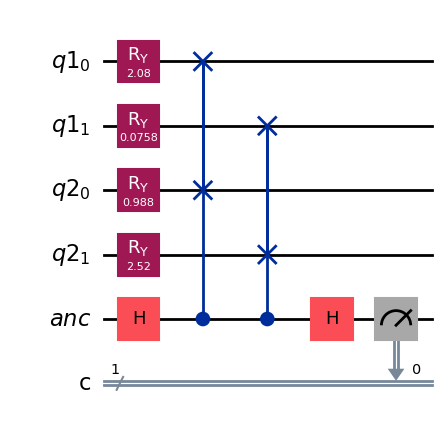

In [14]:
# Create a sample circuit to visualize
sample_data1 = X_train_scaled[0]
sample_data2 = X_train_scaled[1]
demo_circuit, _, _ = create_swap_test_circuit(sample_data1, sample_data2)

print("Sample swap test circuit created with:")
print(f"Data point 1: {sample_data1}")
print(f"Data point 2: {sample_data2}")
print(f"Circuit depth: {demo_circuit.depth()}")
print(f"Number of qubits: {demo_circuit.num_qubits}")

# Print the circuit
print("\nQuantum Circuit Diagram:")
display(demo_circuit.draw(output='mpl', style={'figsize': (14, 10)}))

**Distance Calculation Function**

In [15]:
def quantum_distance(data1, data2, shots=1024, n_features=2):
    """
    Calculate quantum distance between two data points using swap test.

    The swap test gives us P(0) = (1 + |<ψ1|ψ2>|²)/2
    where |<ψ1|ψ2>|² is the overlap between quantum states.

    Args:
        data1, data2: Data points to compare
        shots: Number of quantum measurements
        n_features: Number of features

    Returns:
        distance: Quantum distance measure
    """
    # Create swap test circuit
    circuit, ancilla, classical = create_swap_test_circuit(data1, data2, n_features)

    # Simulate the circuit
    simulator = AerSimulator()
    transpiled_circuit = transpile(circuit, simulator)
    job = simulator.run(transpiled_circuit, shots=shots)
    result = job.result()
    counts = result.get_counts()

    # Calculate probability of measuring 0
    prob_0 = counts.get('0', 0) / shots

    # Convert to distance measure
    # Higher overlap -> lower distance
    # Distance = 1 - overlap_measure
    overlap = 2 * prob_0 - 1  # Convert P(0) to overlap measure
    distance = 1 - abs(overlap)  # Convert overlap to distance

    return distance

**Quantum K-NN Implementation**

In [16]:
class QuantumKNN:
    """
    Quantum K-Nearest Neighbor classifier using swap test for distance calculation.
    """

    def __init__(self, k=3, shots=1024, n_features=2):
        self.k = k
        self.shots = shots
        self.n_features = n_features
        self.X_train = None
        self.y_train = None

    def fit(self, X_train, y_train):
        """Store training data"""
        self.X_train = X_train
        self.y_train = y_train
        print(f"✓ Model fitted with {len(X_train)} training samples")

    def predict_single(self, test_point):
        """Predict class for a single test point"""
        distances = []

        # Calculate quantum distance to each training point
        for i, train_point in enumerate(self.X_train):
            dist = quantum_distance(test_point, train_point,
                                  self.shots, self.n_features)
            distances.append((dist, self.y_train[i]))

        # Sort by distance and get k nearest neighbors
        distances.sort(key=lambda x: x[0])
        k_nearest = distances[:self.k]

        # Vote for the most common class
        votes = {}
        for _, label in k_nearest:
            votes[label] = votes.get(label, 0) + 1

        # Return the class with most votes
        predicted_class = max(votes, key=votes.get)
        return predicted_class, k_nearest

    def predict(self, X_test):
        """Predict classes for multiple test points"""
        predictions = []
        for test_point in X_test:
            pred, _ = self.predict_single(test_point)
            predictions.append(pred)
        return np.array(predictions)

**MODEL TRAINING AND TESTING**

In [17]:
# Initialize quantum k-NN with k=3
qknn = QuantumKNN(k=3, shots=512, n_features=2)  # Using fewer shots for demo

# Fit the model
qknn.fit(X_train_scaled, y_train)

# Test on a few samples (full test set would take very long)
print("Testing on first 5 test samples...")
test_sample_size = 5
X_test_sample = X_test_scaled[:test_sample_size]
y_test_sample = y_test[:test_sample_size]

# Make predictions
print("Making quantum predictions...")
quantum_predictions = []
for i, test_point in enumerate(X_test_sample):
    print(f"  Predicting sample {i+1}/{test_sample_size}...")
    pred, neighbors = qknn.predict_single(test_point)
    quantum_predictions.append(pred)

    print(f"    True class: {y_test_sample[i]}, Predicted: {pred}")
    print(f"    Nearest neighbors (distance, class): {neighbors}")

quantum_predictions = np.array(quantum_predictions)
quantum_accuracy = accuracy_score(y_test_sample, quantum_predictions)

print(f"\nQuantum K-NN Accuracy on sample: {quantum_accuracy:.2f}")

✓ Model fitted with 70 training samples
Testing on first 5 test samples...
Making quantum predictions...
  Predicting sample 1/5...
    True class: 0, Predicted: 0
    Nearest neighbors (distance, class): [(0.0078125, np.int64(0)), (0.0078125, np.int64(0)), (0.01171875, np.int64(0))]
  Predicting sample 2/5...
    True class: 1, Predicted: 1
    Nearest neighbors (distance, class): [(0.0, np.int64(1)), (0.0, np.int64(1)), (0.00390625, np.int64(1))]
  Predicting sample 3/5...
    True class: 0, Predicted: 0
    Nearest neighbors (distance, class): [(0.00390625, np.int64(0)), (0.0078125, np.int64(0)), (0.0078125, np.int64(0))]
  Predicting sample 4/5...
    True class: 0, Predicted: 0
    Nearest neighbors (distance, class): [(0.015625, np.int64(0)), (0.03515625, np.int64(0)), (0.0390625, np.int64(0))]
  Predicting sample 5/5...
    True class: 1, Predicted: 1
    Nearest neighbors (distance, class): [(0.015625, np.int64(1)), (0.015625, np.int64(1)), (0.02734375, np.int64(1))]

Quantum K

**VISUALIZATION**

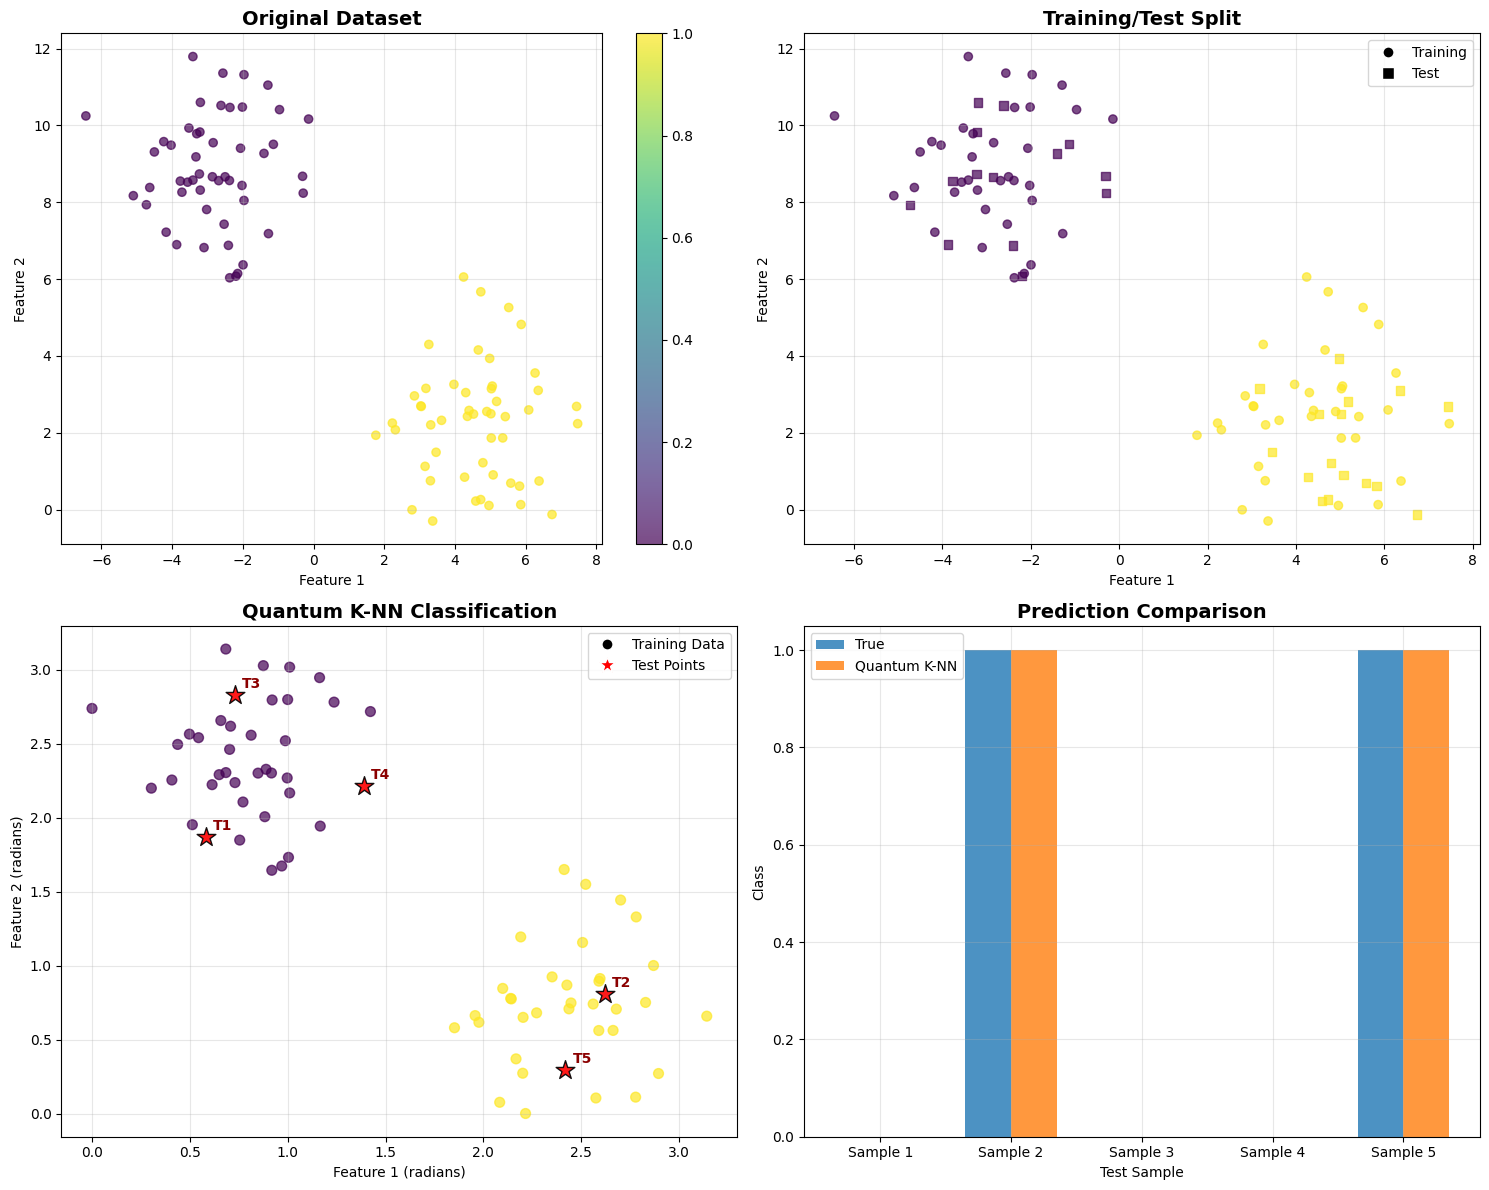

In [18]:
# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Original data
ax1 = axes[0, 0]
scatter = ax1.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', alpha=0.7)
ax1.set_title('Original Dataset', fontsize=14, fontweight='bold')
ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')
ax1.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax1)

# Plot 2: Training/Test split
ax2 = axes[0, 1]
ax2.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis',
           alpha=0.7, label='Training', marker='o')
ax2.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='viridis',
           alpha=0.7, label='Test', marker='s')
ax2.set_title('Training/Test Split', fontsize=14, fontweight='bold')
ax2.set_xlabel('Feature 1')
ax2.set_ylabel('Feature 2')

from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='black',
                         markersize=8, label='Training'),
                  Line2D([0], [0], marker='s', color='w', markerfacecolor='black',
                         markersize=8, label='Test')]
ax2.legend(handles=legend_elements)
ax2.grid(True, alpha=0.3)

# Plot 3: Classification visualization with test points as red asterisks
ax3 = axes[1, 0]
# Plot training data
scatter_train = ax3.scatter(X_train_scaled[:, 0], X_train_scaled[:, 1],
                           c=y_train, cmap='viridis', alpha=0.7, s=50)
# Plot test points being classified as red asterisks
ax3.scatter(X_test_sample[:, 0], X_test_sample[:, 1],
           c='red', marker='*', s=200, alpha=0.9, edgecolors='black', linewidth=1)

ax3.set_title('Quantum K-NN Classification', fontsize=14, fontweight='bold')
ax3.set_xlabel('Feature 1 (radians)')
ax3.set_ylabel('Feature 2 (radians)')

legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='black',
                         markersize=8, label='Training Data'),
                  Line2D([0], [0], marker='*', color='w', markerfacecolor='red',
                         markersize=12, label='Test Points')]
ax3.legend(handles=legend_elements)
ax3.grid(True, alpha=0.3)

# Add text annotations for test points
for i, (x, y) in enumerate(X_test_sample):
    ax3.annotate(f'T{i+1}', (x, y), xytext=(5, 5), textcoords='offset points',
                fontsize=10, fontweight='bold', color='darkred')

# Plot 4: Predictions comparison
ax4 = axes[1, 1]
x_pos = np.arange(len(y_test_sample))
width = 0.35

bars1 = ax4.bar(x_pos - width/2, y_test_sample, width,
               label='True', alpha=0.8)
bars2 = ax4.bar(x_pos + width/2, quantum_predictions, width,
               label='Quantum K-NN', alpha=0.8)

ax4.set_title('Prediction Comparison', fontsize=14, fontweight='bold')
ax4.set_xlabel('Test Sample')
ax4.set_ylabel('Class')
ax4.set_xticks(x_pos)
ax4.set_xticklabels([f'Sample {i+1}' for i in range(len(y_test_sample))])
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()